# COURSERA IBM MACHINE LEARNING CERTIFICATION
## Léa Zurfluh - Feb 2021
### End of module project: Supervised Learning - Regression

Aim of project is to train a few linear regressions on a chosen dataset and present insights to senior audience.

Data set chosen: Gender Pay Gap.

## 1. Brief description of the data set and a summary of its attributes

This Gender Pay Gap data set has been published by Glassdoor and is available [here](https://www.glassdoor.com/research/how-to-analyze-gender-pay-gap-employers-guide/#).
This data set exposes pay and bonus for some characteristics, including gender (see full list of characteristics below). This information comes from a salary survey done in 2019 in the U.S.

1000 rows.

|   |Column attribute |Type  |Comment |
| - | ------- | ------------ | ---- |
| 0	| JobTitle  | object |Ex: Software Engineer  |
| 1	| Gender  | object  |Binary: Male or Female  |
| 2	| Age  | int64  | From 18 to 65  |
| 3	| PerfEval  | int64  |How the employee performs out of 5  |
| 4	| Education  | object  |Highest diploma  |
| 5	| Dept  | object  |Department. Ex: Sales  |
| 6	| Seniority  | int64  |Level of seniority of employee out of 5  |
| 7	| BasePay  | int64  |Annual base salary in USD  |
| 8	| Bonus  | int64  |Annual bonus in USD  |

Let's try to better understand the main drivers of total compensation through various linear regression techniques.


## 2. Data exploration
### I. Data cleaning
The data set is already very clean and does not require further cleaning.
* Add column 'TotalComp' = 'BasePay' + 'Bonus' that we will try to predict later

### II. Feature engineering
##### II.a. Fixing skewness
* Visualise numerical variable as histograms in order to spot skewness
* Remove potential skewness more systematically

##### II.b. Testing for normality
* Conduct a D'Agostino test on all potential outcome variables to understand whether they follow a normal distribution. 
* If they don't, apply a boxcox transformation to make them normal.

### III. Exploratory Data Analysis
##### Do salaries increase with Age at the same rate for Men and Women?
* Visualise how salaries increase with age on average for both men and women
* Test correlation of the difference of salary by age for both genders

### IV. Linear regressions to predict total compensation
##### IV.a. Basic linear regression (no polynomial features added, nor regularisation) 
##### IV.b. Adding polynomial features to the linear regression 
##### IV.c. Adding regularisation with Lasso
* First with the default alpha=1
* Then testing an array of alphas to determine the best one

### V. Conclusion

## <font color = 'blue'> 1. Get the data </font>

In [2]:
### IMPORTS ###
import pandas as pd
import numpy as np
import math
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Normalisation
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
# Correlation
from scipy.stats import pearsonr
from scipy.stats import spearmanr

### VARIABLES ###
FILE = 'Glassdoor Gender Pay Gap.csv'

In [3]:
# Store data set in dataframe
df = pd.read_csv('data/' + FILE)
df.head()

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [3]:
# Adding a 10th column of total compensation
df['TotalComp'] = df['BasePay'] + df['Bonus']

## <font color = 'blue'> 2. Initial Data Exploration </font>
### <font color = 'blue'>I. Data Cleaning </font>
The dataframe seems really clean with no null values, features being in the right type (i.e. no number encoded as string). Moreover, each category of JobTitle, Gender, Education has a similar number of occurrences in the data set.

In [4]:
# Description of dataframe
print('Nb columns: {}'.format(df.shape[1]))
print('Nb rows: {} \n'.format(df.shape[0]))

df.info()

Nb columns: 10
Nb rows: 1000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
JobTitle     1000 non-null object
Gender       1000 non-null object
Age          1000 non-null int64
PerfEval     1000 non-null int64
Education    1000 non-null object
Dept         1000 non-null object
Seniority    1000 non-null int64
BasePay      1000 non-null int64
Bonus        1000 non-null int64
TotalComp    1000 non-null int64
dtypes: int64(6), object(4)
memory usage: 78.2+ KB


Let's try to see the number of categories per object feature.

In [142]:
### Main statistics per possible outcome variable

df[['BasePay', 'Bonus']].describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
BasePay,1000,94472,25337,34208,76850,93327,111558,179726
Bonus,1000,6467,2004,1703,4849,6507,8026,11293


In [5]:
### Categorical variables: how many categories?

for col in df.select_dtypes('object').columns:
    print('Nb of unique values in column {} is: {}'.format(col, len(df[col].unique())))

Nb of unique values in column JobTitle is: 10
Nb of unique values in column Gender is: 2
Nb of unique values in column Education is: 4
Nb of unique values in column Dept is: 5


Everything seems already clean.

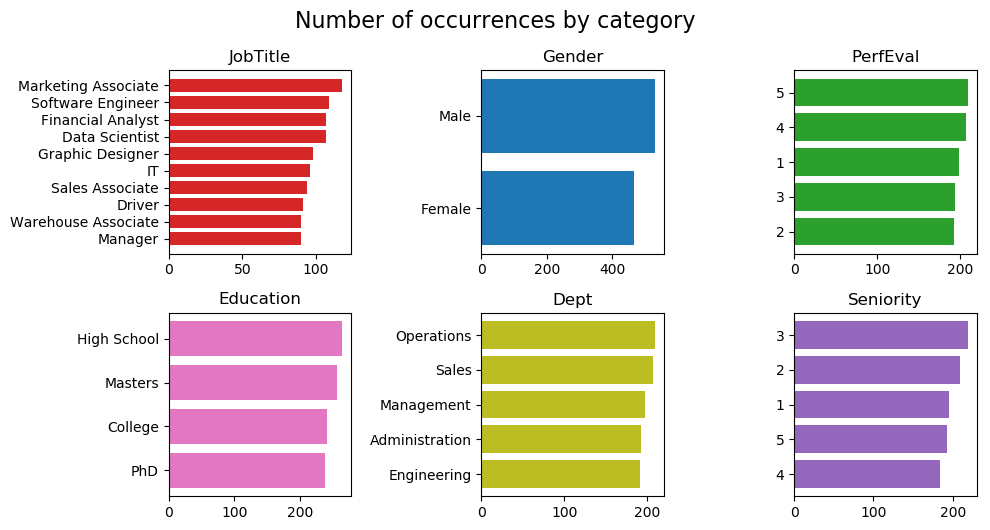

In [6]:
### Let's plot the distribution of all categories to visualise if there are any mismatches

# Categorical columns (changing Seniority and PerfEval to categories)
df2 = df.copy()
df2 = df2.astype({'PerfEval': str, 'Seniority': str})
cat_cols = df2.select_dtypes('object').columns

# Plot of nb of instances by categorical feature
fig, axes = plt.subplots(2, 3, figsize=(10,5), dpi=100)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive', 'tab:purple']

for i, (ax, cat) in enumerate(zip(axes.flatten(), cat_cols)):
    # Count nb of occurrences per category and sort in descending order
    df_temp = pd.DataFrame(df2.groupby(cat)[cat].count()).rename({cat:'nb'}, axis='columns').sort_values(by='nb')
    x=df_temp.index
    y=df_temp['nb']
    ax.barh(x, y, color=colors[i])
    ax.set_title(cat)

plt.suptitle('Number of occurrences by category', y=1.05, size=16)
plt.tight_layout();

The dataset seems really balanced: no category seems sparse or not significant in terms of volume. It can mean 2 things:
* It might not be representative of the population (the insights generated might not be valid to generalise), the generator of the dataframe (Glassdor) might have done some data mining.
* On the other hand, it might facilitate insight generation.

### <font color = 'blue'>II. Feature Engineering </font>
#### <font color = 'blue'>II.a. Fixing Skewness </font>

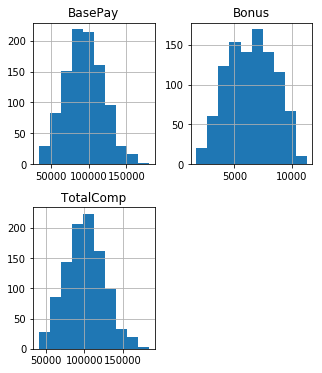

In [7]:
# Visualising numerical variables first
df[['BasePay', 'Bonus', 'TotalComp']].hist(figsize=(5,6));

In [8]:
# Checking skewness. If abs(skewness) > 0.75 let's take the log of the variable. 
# From the charts above, none of the features seems skewed.

num_cols = df.select_dtypes('number').columns
skew_lim = 0.75
skew_vals = df[num_cols].skew()
skew_vals[abs(skew_vals)>=skew_lim].sort_values(ascending=False) # If returns an empty series, nothing is skewed

Series([], dtype: float64)

As suspected above, nothing is skewed according to our rule of spotting skewness > 0.75.

#### <font color = 'blue'>II.b. Testing for normality </font>

None of the potential outcome variables (BasePay, Bonus, TotalComp) seems skewed, meaning they are symmetrical - but let's test for normality using normaltest from scipy (i.e. D'Agostino K^2 Test). If the variable has a normal distribution, the resulting p-value should be as high as possible.
<br>
<br>
Why ensuring target variable is normally distributed? Because one of the main assumptions of linear regression is to have normally distributed residuals. This can be achieved if the target variable itself follows a normal distribution.
<br>
<br>
<b>Assumption: p-value >= 0.05 to consider the tested data as normal

In [9]:
features_to_test = ['BasePay', 'Bonus', 'TotalComp']

for ft in features_to_test:
    pval = normaltest(df[ft])[1]
    if pval > 0.05:
        norm = "normal"
    else: 
        norm = "NOT normal"
    print("{}: p-value is {:.3f} meaning the data is {}".format(ft, pval, norm))

BasePay: p-value is 0.059 meaning the data is normal
Bonus: p-value is 0.000 meaning the data is NOT normal
TotalComp: p-value is 0.077 meaning the data is normal


Of all possible outcome features, only Bonus is not normal. Let's try to normalise it using the BoxCox function (parametrised transformation).

In [10]:
# Using boxcox
bc_result = boxcox(df.Bonus) # returns a tuple. 
boxcox_bonus = bc_result[0] # transformed series
lam = bc_result[1] # lambda, our boxcox parameter

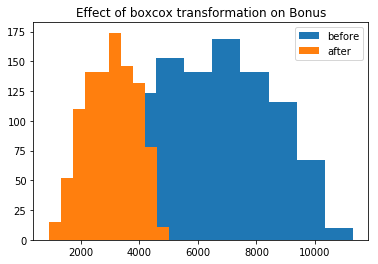

In [11]:
# Let's plot both histograms (before and after transformation)
plt.hist(df.Bonus, label='before')
plt.hist(boxcox_bonus, label='after')
plt.legend()
plt.title('Effect of boxcox transformation on Bonus');

In [12]:
# Let's take a look at the lambda
lam

0.9019574916438604

This lambda will be used for inverse-transforming the predicted variable y_pred, when predicting Bonus. If we do not inverse-transform our predicted variable, we won't be able to compare it to our testing variable y_testas it will not be on the same scale.

### <font color = 'blue'>III. Exploratory data Analysis </font>
#### <font color = 'blue'>Do salaries increase with Age at the same rate for Men and Women?</font>

TotalComp increases with age (the older you are, the more paid). Let's first visualise if the older we get, salary increases are the same for men and women, i.e. that, for each age bin, the difference in compensation for men and women also increases with age.

Then if it is confirmed we will test the correlation of total compensation difference with age.

In [13]:
### Compute mean TotalComp and the difference for men and women, per age binned

# Add a column to bin ages - visualisation will be eased
df['Age_Binned'] = round(df['Age']/5)*5 #Rounds to nearest 5

# Group by age and gender
df_age = df[['Age_Binned', 'TotalComp', 'Gender']].groupby(['Age_Binned', 'Gender']).mean().reset_index()
df_age.TotalComp = df_age.TotalComp/1000

# Pivot the data
df_age = df_age.pivot(index='Age_Binned', columns='Gender', values='TotalComp')

# Add the difference between genders
df_age['Diff'] = df_age['Male'] - df_age['Female']

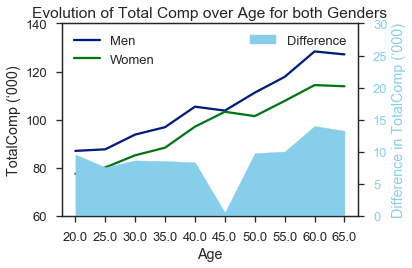

In [148]:
### Visualise the differential in total compensation by age. Assumption: it gets bigger with age.

# Specify x (i.e. age) and y (we will plot 3: 1 line for men's total comp, 1 line for women's, 1 area for the diff)
labels = df_age.index # x
men_means = df_age.Male.values # 1st line to plot
women_means = df_age.Female.values # 2nd line to plot
diff_means = df_age.Diff.values # area to plot

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
line1, = ax.plot(x, men_means, label='Men')
line2, = ax.plot(x, women_means, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TotalComp (‘000)')
ax.set_xlabel('Age')
ax.set_title('Evolution of Total Comp over Age for both Genders')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(60,140)

# Add secodnary y axis for plotting the difference in comp
color='skyblue'
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Difference in TotalComp (‘000)', color=color) 
rect = ax2.fill_between(x, diff_means, label='Difference', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()
ax2.set_ylim(0,30)

fig.tight_layout()

plt.show()



The dark blue and green lines have a positive slope: both genders' salaries increase with age.
However, the difference in Total Comp by age for men and women seem to get bigger for higher ages (the sky blue area seems to get bigger with age). Let's visualise this difference without the bin feature to group ages.

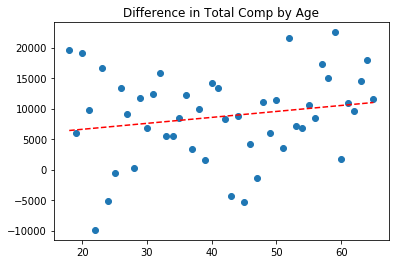

In [15]:
### Plot this total comp difference in a hexbin plot first

# Pivot the main dataframe to have total compensation per gender
df_gender = df[['Gender', 'TotalComp', 'Age']].groupby(['Age', 'Gender']).mean().reset_index()
df_gender = df_gender.pivot(index='Age', columns='Gender', values='TotalComp').reset_index()
df_gender['Diff'] = df_gender.Male - df_gender.Female

x = df_gender.Age
y = df_gender.Diff

plt.scatter(x, y)
plt.title('Difference in Total Comp by Age')

# Calculate the trendline (polynomial function of degree 1)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--");

In [16]:
### Computing correlation (Pearson and Spearman) between Age and Diff in total comp

def significance(pvalue):
    '''input: p-value (float)
    output: string '''
    cr = ''
    if pvalue < 0.05:
        return 'significantly correlated'
    else: return 'not significantly correlated'
    
corrp, pp = pearsonr(df_gender['Age'], df_gender['Diff'])
corrs, ps = spearmanr(df_gender['Age'], df_gender['Diff']) 


print('Pearsons correlation: {:.1%}. The 2 variables are probably {}.'.format(corrp, significance(pp)))
print('Spearmans correlation: {:.1%}. The 2 variables are probably {}.'.format(corrs, significance(ps)))

# Turns out both correlation coefficients are negative, suggesting an inverse relationship between cocoa % and rating!

Pearsons correlation: 18.9%. The 2 variables are probably not significantly correlated.
Spearmans correlation: 15.9%. The 2 variables are probably not significantly correlated.


After testing both Pearson and Spearman correlation and finding non significant results, we cannot conclude about a correlation of Age and Difference in total comp.

### <font color = 'blue'>IV. Linear Regression modelling </font>
#### <font color = 'blue'>IV.a. Basic linear regression (no polynomial features added, nor regularisation) </font>

Those linear regressions trained on this data set will hopefully show some indications about the importance of certain features in comparison of others.

Let's focus on TotalComp as the outcome variable.

In [32]:
### IMPORTS
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)
from sklearn.metrics import mean_squared_error

In [18]:
### Copy the dataframe for Linear Regression 1
df1 = df.copy()

In [19]:
# Pre-processing: map Education to 0-1-2-3
dict={'High School':0, 'College':1, 'Masters':2, 'PhD':3}
df1.Education = df1.Education.map(dict)

In [20]:
# Pre-processing: map Gender to 0-1
dict={'Male':0, 'Female':1}
df1.Gender = df1.Gender.map(dict)

In [21]:
df1 = pd.get_dummies(df1, drop_first=True)

In [22]:
# Separate x and y datasets
x1=df1.drop(['BasePay', 'Bonus', 'TotalComp', 'Age_Binned'], axis=1)
y1=df1['TotalComp']

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.3, random_state=7879)

In [23]:
# Scale X_train1 and X_test1 so that all features are on the same scale
s1 = StandardScaler()
X_train1ss = s1.fit_transform(X_train1)
X_test1ss = s1.fit_transform(X_test1)

/Users/leazurfluh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/leazurfluh/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/leazurfluh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/leazurfluh/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
# Fit regression and transform testing data
lr1 = LinearRegression() 
lr1.fit(X_train1ss, y_train1)
y_train_pred1 = lr1.predict(X_train1ss)
y_test_pred1 = lr1.predict(X_test1ss)

In [25]:
# Calculate Root Mean Squared Error, as well as the r2
rmse_train1 = np.sqrt(mean_squared_error(y_train1, y_train_pred1))
rmse_test1 = np.sqrt(mean_squared_error(y_test1, y_test_pred1))
r2_1 = r2_score(y_test_pred1, y_test1)

print('RMSE(train) = {:.0f}'.format(rmse_train1))
print('RMSE(test) = {:.0f}'.format(rmse_test1))
print('R2 score = {:.3f}'.format(r2_1))

RMSE(train) = 9833
RMSE(test) = 10768
R2 score = 0.800


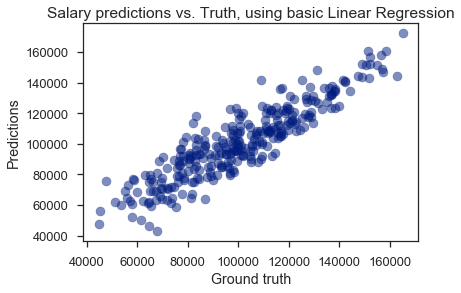

In [26]:
# Plot predictions vs actual.
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test1, y_test_pred1, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Salary predictions vs. Truth, using basic Linear Regression');

The regression performs quite well on the test sample, with a R2 of 0.80. It is also visually confirmed with the scatter plot of predictions vs. true values above.

In [154]:
# Understanding the coefficients
coeffs = pd.DataFrame(list(zip(x1.columns, lr1.coef_))).set_index(0).sort_values(1).astype(int)
coeffs

,1
0,
JobTitle_Marketing Associate,-5128
JobTitle_Driver,-1013
JobTitle_Graphic Designer,-914
JobTitle_IT,-529
Gender,-334
JobTitle_Warehouse Associate,-315
Dept_Operations,134
JobTitle_Sales Associate,437
JobTitle_Financial Analyst,1066


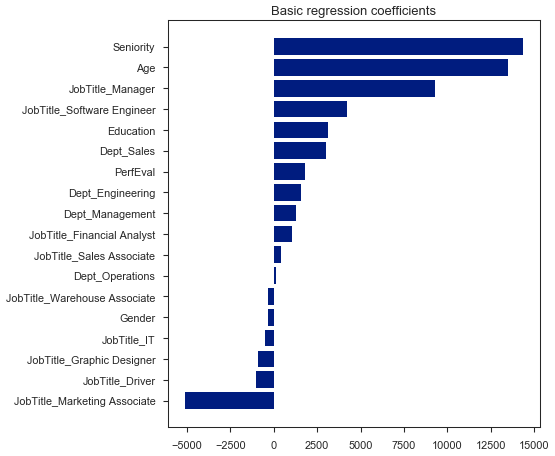

In [159]:
# Visualisation

fig, ax = plt.subplots(figsize=(8,9), dpi=60)
ax.barh(coeffs.index, coeffs[1])
ax.set_title('Basic regression coefficients');

Unsurprisingly, Gender seems to be a deterrent to higher compensation - however in terms of magnitude, Gender's coefficient seems to not be the main driver of total compensation. We will verify if it is significant while doing regularisation later.

On the other end of the spectrum, it seems quite sensible to have both Seniority and Age as the main driver for a high salary.

#### <font color = 'blue'>IV.b. Adding polynomial features to the linear regression </font>

In [28]:
# Take same data set as in the first regression
df2 = df1.copy()
x2=df2.drop(['BasePay', 'Bonus', 'TotalComp', 'Age_Binned'], axis=1)
y2=df2['TotalComp']

# Adding polynomial features of degree 2
pf = PolynomialFeatures(degree=2, include_bias=False)
X2 = pf.fit_transform(x2)

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=7879)

# Scale X_train2 and X_test2 so that all features are on the same scale
s2 = StandardScaler()
X_train2ss = s2.fit_transform(X_train2)
X_test2ss = s2.fit_transform(X_test2)

# Fit regression and transform testing data
lr2 = LinearRegression()
lr2.fit(X_train2ss, y_train2)
y_train_pred2 = lr2.predict(X_train2ss)
y_test_pred2 = lr2.predict(X_test2ss)

# Calculate Root Mean Squared Error, as well as the r2
rmse_train2 = np.sqrt(mean_squared_error(y_train2, y_train_pred2))
rmse_test2 = np.sqrt(mean_squared_error(y_test2, y_test_pred2))
r2_2 = r2_score(y_test_pred2, y_test2)

print('RMSE(train, polynomial features of degree 2) = {:.0f}'.format(rmse_train2))
print('RMSE(test, polynomial features of degree 2) = {:.0f}'.format(rmse_test2))
print('R2 score, polynomial features of degree 2 = {:.3f}'.format(r2_2))

RMSE(train, polynomial features of degree 2) = 9035
RMSE(test, polynomial features of degree 2) = 11516
R2 score, polynomial features of degree 2 = 0.760


The root mean squared error of the train test is lower when we add polynomial features of degree 2 than the basic linear regression, however it is higher on the test set and the R2 is a bit lower.
This is due to overfitting of the model: the train set fits nicely, but when testing on a different set it does not work as well.

#### <font color = 'blue'>IV.c. Adding regularisation with Lasso </font>

We are focussing on interpretability of the coefficients, and it would be nice to have some of them equal to zero in order to conclude they don't bring anything to the table: that is why we are using Lasso. 

Let's first add polynomial features of degree 2, then use Lasso to determine which ones are the most important.

In [59]:
# Take same data set as in the first two regressions
df3 = df1.copy()
x3=df3.drop(['BasePay', 'Bonus', 'TotalComp', 'Age_Binned'], axis=1)
y3=df3['TotalComp']

# Adding polynomial features of degree 2 to be able to apply Lasso after
pf_3 = PolynomialFeatures(degree=2, include_bias=False)
X3 = pf_3.fit_transform(x3)

In [60]:
# Train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=7879)

# Scale X_train3 and X_test3 so that all features are on the same scale
s3 = StandardScaler()
X_train3ss = s3.fit_transform(X_train3)
X_test3ss = s3.fit_transform(X_test3)

In [61]:
# Mute the sklearn warning about regularisation
import warnings
warnings.filterwarnings('ignore', module='sklearn')

In [160]:
# Fit regression and transform testing data
las3 = Lasso()
las3.fit(X_train3ss, y_train3)
y_train_pred3 = las3.predict(X_train3ss)
y_test_pred3 = las3.predict(X_test3ss)

# Calculate Root Mean Squared Error, as well as the r2
rmse_train3 = np.sqrt(mean_squared_error(y_train3, y_train_pred3))
rmse_test3 = np.sqrt(mean_squared_error(y_test3, y_test_pred3))
r2_3 = r2_score(y_test_pred3, y_test3)

print('RMSE(train, Lasso) = {:.0f}'.format(rmse_train3))
print('RMSE(test, Lasso) = {:.0f}'.format(rmse_test3))
print('R2 score, Lasso = {:.3f}'.format(r2_3))

RMSE(train, Lasso) = 8972
RMSE(test, Lasso) = 11317
R2 score, Lasso = 0.773


While the error of the train set is the lowest so far, the one of the test set is higher. With a R2 lower than the one of the basic regression, it shows some overfitting. Let's thus test several alphas in order to reduce the testing set RMSE and increase the R2.

Because the default alpha value is 1 for Lasso and we still see overfitting, we are going to test alphas higher than 1 in order to push down more features to zero.

In [80]:
# Different alphas
alphas = [0.01, 0.1, 1, 5, 10, 15, 30, 80, 100, 150, 200, 300, 400, 500, 600]
R2s = []
RMSE_train = []
RMSE_test = []

for a in alphas:
    las4 = Lasso(alpha=a,max_iter=5e6)
    las4.fit(X_train3ss, y_train3)
    y_train_pred4 = las4.predict(X_train3ss)
    y_test_pred4 = las4.predict(X_test3ss)
    
    R2s.append(r2_score(y_test_pred4, y_test3))
    RMSE_train.append(np.sqrt(mean_squared_error(y_train3, y_train_pred4)))
    RMSE_test.append(np.sqrt(mean_squared_error(y_test3, y_test_pred4)))

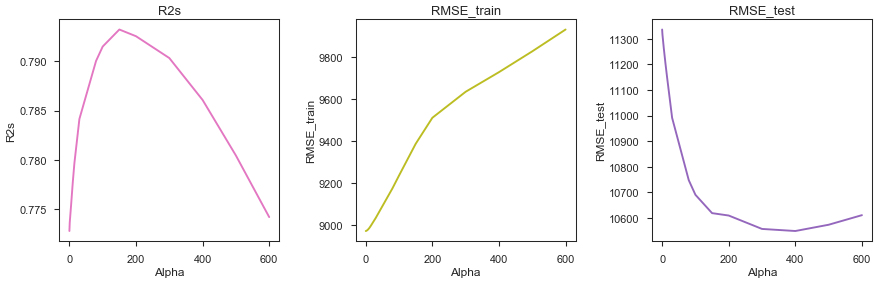

In [94]:
# Visualising R2s
fig, axes = plt.subplots(1, 3, figsize=(15,5), dpi=60)
colors = ['tab:pink', 'tab:olive', 'tab:purple']
metrics = [R2s, RMSE_train, RMSE_test]
metrics_names = ['R2s', 'RMSE_train', 'RMSE_test']

for i, (ax, metric) in enumerate(zip(axes.flatten(), metrics)):
    ax.plot(alphas, metric, color=colors[i])
    ax.set_title(metrics_names[i])
    ax.set_ylabel(metrics_names[i])
    ax.set_xlabel('Alpha')

#plt.suptitle('Number of occurrences by category', y=1.05, size=16)
plt.tight_layout();


In [96]:
### Which alpha leads to the highest R2?

alphas_R2 = list(zip(alphas, R2s, RMSE_train, RMSE_test))

# take second element for sort
def takeSecond(elem):
    return elem[1]

# sort list with key
alphas_R2.sort(key=takeSecond, reverse=True)
alphas_R2[0]

(150, 0.7932495362976943, 9386.230384524297, 10619.152007317329)

In [97]:
### Which alpha leads to the lowest RMSE_test?

# take fourth element for sort
def takeFourth(elem):
    return elem[3]

# sort list with key
alphas_R2.sort(key=takeFourth, reverse=False)
alphas_R2[0]

(400, 0.7860752583521821, 9726.530145701403, 10549.429827655233)

From above, we see that:
* An alpha of 150 leads to the highest R2 = 0.793, but
* An alpha of 400 leads to the lowest test RMSE = 10549.

The difference might be explained by the absence of cross validation.

<b> Coefficient interpretation

In [100]:
# Let's re-fit the model with alpha = 400 to focus on interpretability
lasso = Lasso(alpha=400,max_iter=5e6)
lasso.fit(X_train3ss, y_train3)

Lasso(alpha=400, copy_X=True, fit_intercept=True, max_iter=5000000.0,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [102]:
# Retrieve the name of polynomial features in order to understand which coefficients have the most impact
pf_cols = pf_3.get_feature_names(x3.columns)

In [121]:
# Zip pf_cols with lasso coefficients
coeff = pd.DataFrame(list(zip(pf_cols, lasso.coef_)))
coeff.columns = ['pf_col', 'coefficient']

In [124]:
len(coeff)

43

In [123]:
coeff = coeff.loc[(coeff!=0).all(axis=1)]
coeff.sort_values('coefficient', inplace=True)

In [125]:
coeff

,pf_col,coefficient
10,JobTitle_Marketing Associate,-4226.311096
85,Seniority JobTitle_Driver,-476.681850
166,JobTitle_Sales Associate Dept_Operations,-413.613261
45,Age JobTitle_Marketing Associate,-411.499663
7,JobTitle_Graphic Designer,-334.460684
18,Gender^2,-254.007341
141,JobTitle_IT Dept_Management,-241.707960
64,PerfEval JobTitle_Warehouse Associate,-118.808398
56,PerfEval JobTitle_Driver,-81.515699
151,JobTitle_Manager Dept_Operations,-71.207421


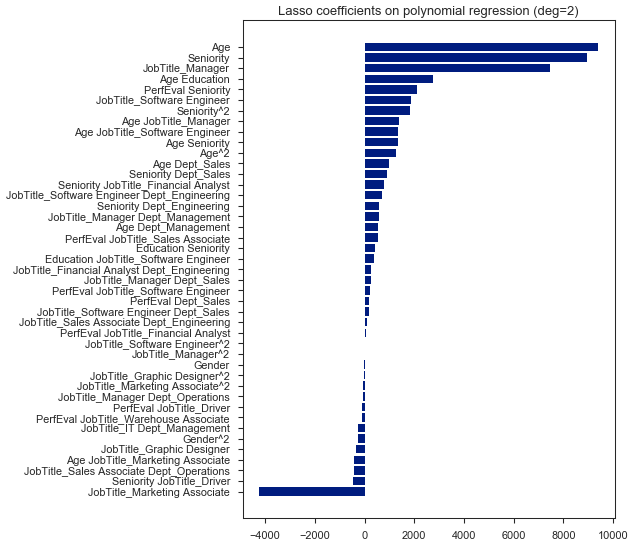

In [137]:
fig, ax = plt.subplots(figsize=(8,11), dpi=60)
ax.barh(coeff.pf_col, coeff.coefficient)
ax.set_title('Lasso coefficients on polynomial regression (deg=2)');

This confirms the basic regression we did above in IV.a.:
* Features most likely to increase total compensation are Seniority, Age, and whether you are a Manager.
* At the other end of the spectrum, if you are a Marketing Associate, you are likely to have a lower salary.
* To a lower extent, Senior Drivers, Older Marketing Associates and Graphic Designers are also likely to have a lower salary.
* Gender ^2 is next, showing that even if it doesn't have the highest effect (fortunately...) it is still an impactful factor in salary.

### <font color = 'blue'>V. Conclusion </font>
##### <font color = 'blue'> V.a. Summary </font>

The aim of this project was to understand the effect of Gender on compensation. 

1. In order to do that, I first tried to prove the correlation between age and the difference in compensation between men and women (i.e. the difference in compensation increases with age), but the correlation test did not show significant results.

2. Then, I conducted a basic linear regression with all the features available. The $R^2$ achieved was 0.80.

3. When adding polynomial features of degree 2, the $R^2$ fell to 0.76. This indicates overfitting.

4. Finally, I used Lasso with first an alpha=1 and then a series of alphas to determine whether the prediction could be improved and more features to be reduced to 0 to ease interpretability. An alpha of 150 led to $R^2$ of 0.79 while a higher alpha of 400 led to a slightly lower $R^2$ of 0.789 but a higher number of zeroed coefficients. This was the retained alpha.

5. The study of coefficients showed what could be already seen with a basic regression: the main factors of higher salaries are Seniority, Age, and being a Manager. Gender still seems a significant deterrent, while not the most important one.


<b> Had I only done a vanilla regression, I would still have had some good insights as well as a good prediction model. Basic linear regression is thus the validated model. </b>

Also as mentioned at the top of this paper, the data set was published cleaned and might not be representative of the population - those insights and prediction model are thus to be taken with caution.

##### <font color = 'blue'> V.b. Next steps </font>

I have chosen to use a train/test split and not cross validation: a natural next step would be to verify those results using cross validation.

Moreover I used Lasso but we could do the same exercise with Ridge and/or ElasticNet once again to check those results. 

I do not think increasing the degree of polynomial features would be beneficial if our focus is interpretability as it is difficult to interpret cross coefficients.

Of course, checking if we could achieve similar results on a raw dataset that has not been cleaned beforehand or only slightly could also be interesting.